# **LearningRate fijo (Adam)**

## **Importar dataset**

In [ ]:
import kagglehub    # Libreria para la descarga de archivos de kaggle

# Download latest version
path = kagglehub.dataset_download("gpiosenka/railway-track-fault-detection-resized-224-x-224")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/railway-track-fault-detection-resized-224-x-224


## **Directorios**

In [ ]:
# Necesitaremos la librería os, que nos permite interactuar con el sistema operativo y manipular rutas.
import os

# Directorio de entrenamiento:
train_dir = os.path.join(path, 'train')
# Directorio de pruebas:
test_dir = os.path.join(path, 'test')
# Directorio de validacion:
valid_dir = os.path.join(path, 'valid')

## **Importar modelos**

In [ ]:
# Los modelos pre-entrenados se encontrarán en la librería de tensorflow.
import tensorflow as tf

# Aprovechamos para fijar la semilla y evitar la aleatoriedad entre simulaciones.
import random
import numpy as np

# Fijar semillas
Semilla = 42
os.environ['PYTHONHASHSEED'] = str(Semilla) # Controlamos la aleatoridad en el hashing de objetos.
random.seed(Semilla)                        # Controlamos la aleatoridad en la generación de números aleatorios.
np.random.seed(Semilla)                     # Controlamos la aleatoridad en la generación de números aleatorios en numpy.
tf.random.set_seed(Semilla)                 # Controlamos la aleatoridad en la generación de números aleatorios en tensorflow.

# Configurar comportamiento determinista en TensorFlow
os.environ['TF_DETERMINISTIC_OPS'] = '1'    # Configuramos una variable de entorno destinada a ciertas operaciones no deterministas como deterministas.

### VGG16

In [ ]:
def modelo_base ():
  VGG16_Base = (tf.keras.applications.VGG16(include_top=False,        # Eliminamos su clasificador.
                                          weights='imagenet',         # Mantenemos los pesos de cada capa.
                                          input_shape=(224, 224, 3))) # Especificamos el tamaño de los datos de entrada.
  # Congelamos el modelo.
  for layer in VGG16_Base.layers:
    layer.trainable = False
  return VGG16_Base

## **Entrenamiento**

### Datos de entrada

In [ ]:
# Importamos la clase ImageDataGenerator contenido en Keras.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)

# Definimos los generadores para cada uno de los conjuntos.
train_data = datagen.flow_from_directory(
    train_dir,                 # Directorio de datos original.
    batch_size=32,             # Cantidad de datos por iteración.
    class_mode='categorical',  # Tipo categórico (defectuoso y no defectuoso).
    color_mode="rgb",          # Escala de colores.
    target_size=(224, 224),    # Tamaño de los datos a la salida.
    subset='training'          # Nombre del subset originado.
)
validation_data = datagen.flow_from_directory(
    valid_dir,                 # Directorio de datos original.
    batch_size=32,             # Cantidad de datos por iteración.
    class_mode='categorical',  # Tipo categórico (defectuoso y no defectuoso).
    color_mode="rgb",          # Escala de colores.
    target_size=(224, 224),    # Tamaño de los datos a la salida.
    shuffle=False              # Mezcla de los datos.
)
test_data = datagen.flow_from_directory(
    test_dir,                  # Directorio de datos original.
    batch_size=32,             # Cantidad de datos por iteración.
    class_mode='categorical',  # Tipo categórico (defectuoso y no defectuoso).
    color_mode="rgb",          # Escala de colores.
    target_size=(224, 224),    # Tamaño de los datos a la salida.
    shuffle=False              # Mezcla de los datos.
)

Found 299 images belonging to 2 classes.
Found 62 images belonging to 2 classes.
Found 22 images belonging to 2 classes.


### Modelo VGG16 (0.01)

In [ ]:
# Definimos el modelo base
VGG16_Base = modelo_base()

# Creamos un modelo nuevo.
VGG16_001 = tf.keras.Sequential()

# Introducimos primero el modelo pre-entrenado sin clasificador.
VGG16_001.add(VGG16_Base)

# Añadimos el clasificador categórico.
VGG16_001.add(tf.keras.layers.Flatten())
VGG16_001.add(tf.keras.layers.Dense(500, activation='relu'))
VGG16_001.add(tf.keras.layers.Dense(200, activation='relu'))
VGG16_001.add(tf.keras.layers.Dense(2, activation='sigmoid'))

# Observamos el modelo resultante.
VGG16_001.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │    12,544,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           402 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,359,790 (104.37 MB)

 Trainable params: 12,645,102 (48.24 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Para realizar la simulación o entrenamiento emplearemos dos librerías.
from keras import optimizers # Contiene optimizadores, encargados de ajustar los pesos.
import time

In [ ]:
# Compilamos el modelo antes definido.
VGG16_001.compile(loss='categorical_crossentropy',
                optimizer=optimizers.Adam(learning_rate = 0.01),
                metrics=['acc'])

# Realizamos el entrenamiento.
VGG16_001_start_time = time.time()
VGG16_001_history = VGG16_001.fit(
    train_data,
    epochs=10,
    validation_data=validation_data)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 474ms/step - acc: 0.5547 - loss: 78.3221 - val_acc: 0.5000 - val_loss: 1.6815
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 265ms/step - acc: 0.5277 - loss: 5.7826 - val_acc: 0.7903 - val_loss: 0.8750
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 280ms/step - acc: 0.7756 - loss: 0.7798 - val_acc: 0.8226 - val_loss: 0.4202
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 269ms/step - acc: 0.8844 - loss: 0.3160 - val_acc: 0.6774 - val_loss: 0.7226
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step - acc: 0.8842 - loss: 0.2520 - val_acc: 0.8710 - val_loss: 0.3838
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - acc: 0.9423 - loss: 0.1284 - val_acc: 0.8065 - val_loss: 0.5341
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step - acc: 0.9864 - loss: 0.0617 - val_acc: 0.8871 - val_loss: 0.3697
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 265ms/step - acc: 0.9929 - loss: 0.0197 - val_acc: 0.8710 - val_loss: 0.3993
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 267ms/step - a

In [ ]:
# Obtenemos los parametros de interes de la simulacion.
VGG16_001_acc1 = VGG16_001_history.history['acc']
VGG16_001_val_acc1 = VGG16_001_history.history['val_acc']
VGG16_001_loss1 = VGG16_001_history.history['loss']
VGG16_001_val_loss1 = VGG16_001_history.history['val_loss']

In [ ]:
# Ahora descongelamos las últimas capas y volvemos a simular.
for layer in VGG16_Base.layers[-2:]:
    layer.trainable = True

# Compilamos nuevamente el modelo
VGG16_001.compile(loss='categorical_crossentropy',
                optimizer=optimizers.Adam(learning_rate = 0.01),
                metrics=['acc'])

# Realizamos el entrenamiento.
VGG16_001_history = VGG16_001.fit(
    train_data,
    epochs=5,
    validation_data=validation_data)
VGG16_001_end_time = time.time()
print(f"Tiempo de ejecución: {VGG16_001_end_time - VGG16_001_start_time} segundos")

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 398ms/step - acc: 0.5620 - loss: 142.8618 - val_acc: 0.5000 - val_loss: 5.3659
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 281ms/step - acc: 0.4634 - loss: 8.8531 - val_acc: 0.3710 - val_loss: 0.8279
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 286ms/step - acc: 0.4731 - loss: 1.3676 - val_acc: 0.4839 - val_loss: 0.7155
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 270ms/step - acc: 0.5312 - loss: 0.7572 - val_acc: 0.5000 - val_loss: 0.6897
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 279ms/step - acc: 0.5953 - loss: 0.6652 - val_acc: 0.8065 - val_loss: 0.4734
Tiempo de ejecución: 63.975573778152466 segundos


In [ ]:
# Obtenemos los parametros de interes de la simulacion.
VGG16_001_acc2 = VGG16_001_history.history['acc']
VGG16_001_val_acc2 = VGG16_001_history.history['val_acc']
VGG16_001_loss2 = VGG16_001_history.history['loss']
VGG16_001_val_loss2 = VGG16_001_history.history['val_loss']

### Modelo VGG16 (0.005)

In [ ]:
# Definimos el modelo base
VGG16_Base = modelo_base()

# Creamos un modelo nuevo.
VGG16_0005 = tf.keras.Sequential()

# Introducimos primero el modelo pre-entrenado sin clasificador.
VGG16_0005.add(VGG16_Base)

# Añadimos el clasificador categórico.
VGG16_0005.add(tf.keras.layers.Flatten())
VGG16_0005.add(tf.keras.layers.Dense(500, activation='relu'))
VGG16_0005.add(tf.keras.layers.Dense(200, activation='relu'))
VGG16_0005.add(tf.keras.layers.Dense(2, activation='sigmoid'))

# Observamos el modelo resultante.
VGG16_0005.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 500)            │    12,544,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           402 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,359,790 (104.37 MB)

 Trainable params: 12,645,102 (48.24 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Para realizar la simulación o entrenamiento emplearemos dos librerías.
from keras import optimizers # Contiene optimizadores, encargados de ajustar los pesos.
import time

In [ ]:
# Compilamos el modelo antes definido.
VGG16_0005.compile(loss='categorical_crossentropy',
                optimizer=optimizers.Adam(learning_rate = 0.005),
                metrics=['acc'])

# Realizamos el entrenamiento.
VGG16_0005_start_time = time.time()
VGG16_0005_history = VGG16_0005.fit(
    train_data,
    epochs=10,
    validation_data=validation_data)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - acc: 0.4192 - loss: 35.2347 - val_acc: 0.5000 - val_loss: 3.2598
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 249ms/step - acc: 0.5430 - loss: 2.2700 - val_acc: 0.7581 - val_loss: 0.7248
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - acc: 0.7423 - loss: 0.8226 - val_acc: 0.7903 - val_loss: 0.6429
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 277ms/step - acc: 0.9002 - loss: 0.2861 - val_acc: 0.8065 - val_loss: 0.4550
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 286ms/step - acc: 0.8733 - loss: 0.3240 - val_acc: 0.8226 - val_loss: 0.4167
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 281ms/step - acc: 0.9596 - loss: 0.1343 - val_acc: 0.7903 - val_loss: 0.4960
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - acc: 0.9734 - loss: 0.1094 - val_acc: 0.8387 - val_loss: 0.3877
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 300ms/step - acc: 1.0000 - loss: 0.0646 - val_acc: 0.8065 - val_loss: 0.4539
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 295ms/step - a

In [ ]:
# Obtenemos los parametros de interes de la simulacion.
VGG16_0005_acc1 = VGG16_0005_history.history['acc']
VGG16_0005_val_acc1 = VGG16_0005_history.history['val_acc']
VGG16_0005_loss1 = VGG16_0005_history.history['loss']
VGG16_0005_val_loss1 = VGG16_0005_history.history['val_loss']

In [ ]:
# Ahora descongelamos las últimas capas y volvemos a simular.
for layer in VGG16_Base.layers[-2:]:
    layer.trainable = True

# Compilamos nuevamente el modelo
VGG16_0005.compile(loss='categorical_crossentropy',
                optimizer=optimizers.Adam(learning_rate = 0.005),
                metrics=['acc'])

# Realizamos el entrenamiento.
VGG16_0005_history = VGG16_0005.fit(
    train_data,
    epochs=5,
    validation_data=validation_data)
VGG16_0005_end_time = time.time()
print(f"Tiempo de ejecución: {VGG16_0005_end_time - VGG16_0005_start_time} segundos")

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 363ms/step - acc: 0.6669 - loss: 33.8748 - val_acc: 0.6774 - val_loss: 0.5706
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 296ms/step - acc: 0.6646 - loss: 0.5658 - val_acc: 0.7903 - val_loss: 0.4357
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - acc: 0.8156 - loss: 0.4032 - val_acc: 0.7581 - val_loss: 0.4897
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 260ms/step - acc: 0.8895 - loss: 0.2765 - val_acc: 0.8548 - val_loss: 0.3414
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 264ms/step - acc: 0.9109 - loss: 0.1921 - val_acc: 0.8065 - val_loss: 0.5046
Tiempo de ejecución: 60.407503843307495 segundos


In [ ]:
# Obtenemos los parametros de interes de la simulacion.
VGG16_0005_acc2 = VGG16_0005_history.history['acc']
VGG16_0005_val_acc2 = VGG16_0005_history.history['val_acc']
VGG16_0005_loss2 = VGG16_0005_history.history['loss']
VGG16_0005_val_loss2 = VGG16_0005_history.history['val_loss']

### Modelo VGG16 (0.001)

In [ ]:
# Definimos el modelo base
VGG16_Base = modelo_base()

# Creamos un modelo nuevo.
VGG16_0001 = tf.keras.Sequential()

# Introducimos primero el modelo pre-entrenado sin clasificador.
VGG16_0001.add(VGG16_Base)

# Añadimos el clasificador categórico.
VGG16_0001.add(tf.keras.layers.Flatten())
VGG16_0001.add(tf.keras.layers.Dense(500, activation='relu'))
VGG16_0001.add(tf.keras.layers.Dense(200, activation='relu'))
VGG16_0001.add(tf.keras.layers.Dense(2, activation='sigmoid'))

# Observamos el modelo resultante.
VGG16_0001.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 500)            │    12,544,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │           402 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,359,790 (104.37 MB)

 Trainable params: 12,645,102 (48.24 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Para realizar la simulación o entrenamiento emplearemos dos librerías.
from keras import optimizers # Contiene optimizadores, encargados de ajustar los pesos.
import time

In [ ]:
# Compilamos el modelo antes definido.
VGG16_0001.compile(loss='categorical_crossentropy',
                optimizer=optimizers.Adam(learning_rate = 0.001),
                metrics=['acc'])

# Realizamos el entrenamiento.
VGG16_0001_start_time = time.time()
VGG16_0001_history = VGG16_0001.fit(
    train_data,
    epochs=10,
    validation_data=validation_data)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - acc: 0.4591 - loss: 4.5335 - val_acc: 0.6290 - val_loss: 0.8123
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 250ms/step - acc: 0.6980 - loss: 0.6089 - val_acc: 0.8065 - val_loss: 0.4097
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 279ms/step - acc: 0.8081 - loss: 0.4148 - val_acc: 0.8710 - val_loss: 0.3948
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 271ms/step - acc: 0.8543 - loss: 0.3006 - val_acc: 0.6129 - val_loss: 0.6095
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - acc: 0.8983 - loss: 0.2298 - val_acc: 0.8710 - val_loss: 0.3956
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 291ms/step - acc: 0.9669 - loss: 0.1056 - val_acc: 0.8710 - val_loss: 0.3837
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 292ms/step - acc: 1.0000 - loss: 0.0620 - val_acc: 0.8871 - val_loss: 0.3655
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 250ms/step - acc: 1.0000 - loss: 0.0322 - val_acc: 0.8710 - val_loss: 0.3478
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 288ms/step - ac

In [ ]:
# Obtenemos los parametros de interes de la simulacion.
VGG16_0001_acc1 = VGG16_0001_history.history['acc']
VGG16_0001_val_acc1 = VGG16_0001_history.history['val_acc']
VGG16_0001_loss1 = VGG16_0001_history.history['loss']
VGG16_0001_val_loss1 = VGG16_0001_history.history['val_loss']

In [ ]:
# Ahora descongelamos las últimas capas y volvemos a simular.
for layer in VGG16_Base.layers[-2:]:
    layer.trainable = True

# Compilamos nuevamente el modelo
VGG16_0001.compile(loss='categorical_crossentropy',
                optimizer=optimizers.Adam(learning_rate = 0.001),
                metrics=['acc'])

# Realizamos el entrenamiento.
VGG16_0001_history = VGG16_0001.fit(
    train_data,
    epochs=5,
    validation_data=validation_data)
VGG16_0001_end_time = time.time()
print(f"Tiempo de ejecución: {VGG16_0001_end_time - VGG16_0001_start_time} segundos")

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 376ms/step - acc: 0.7470 - loss: 2.6551 - val_acc: 0.8226 - val_loss: 0.4057
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 281ms/step - acc: 0.8760 - loss: 0.2811 - val_acc: 0.8387 - val_loss: 0.4187
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 295ms/step - acc: 0.9775 - loss: 0.1001 - val_acc: 0.8387 - val_loss: 0.4361
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 259ms/step - acc: 0.9955 - loss: 0.0208 - val_acc: 0.6774 - val_loss: 1.6218
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 295ms/step - acc: 0.9716 - loss: 0.0773 - val_acc: 0.7742 - val_loss: 0.7463
Tiempo de ejecución: 62.78954839706421 segundos


In [ ]:
# Obtenemos los parametros de interes de la simulacion.
VGG16_0001_acc2 = VGG16_0001_history.history['acc']
VGG16_0001_val_acc2 = VGG16_0001_history.history['val_acc']
VGG16_0001_loss2 = VGG16_0001_history.history['loss']
VGG16_0001_val_loss2 = VGG16_0001_history.history['val_loss']

### Modelo VGG16 (0.0001)

In [ ]:
# Definimos el modelo base
VGG16_Base = modelo_base()

# Creamos un modelo nuevo.
VGG16_00001 = tf.keras.Sequential()

# Introducimos primero el modelo pre-entrenado sin clasificador.
VGG16_00001.add(VGG16_Base)

# Añadimos el clasificador categórico.
VGG16_00001.add(tf.keras.layers.Flatten())
VGG16_00001.add(tf.keras.layers.Dense(500, activation='relu'))
VGG16_00001.add(tf.keras.layers.Dense(200, activation='relu'))
VGG16_00001.add(tf.keras.layers.Dense(2, activation='sigmoid'))

# Observamos el modelo resultante.
VGG16_00001.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 500)            │    12,544,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           402 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,359,790 (104.37 MB)

 Trainable params: 12,645,102 (48.24 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Para realizar la simulación o entrenamiento emplearemos dos librerías.
from keras import optimizers # Contiene optimizadores, encargados de ajustar los pesos.
import time

In [ ]:
# Compilamos el modelo antes definido.
VGG16_00001.compile(loss='categorical_crossentropy',
                optimizer=optimizers.Adam(learning_rate = 0.0001),
                metrics=['acc'])

# Realizamos el entrenamiento.
VGG16_00001_start_time = time.time()
VGG16_00001_history = VGG16_00001.fit(
    train_data,
    epochs=10,
    validation_data=validation_data)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 353ms/step - acc: 0.6560 - loss: 0.5939 - val_acc: 0.8065 - val_loss: 0.4495
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 287ms/step - acc: 0.8817 - loss: 0.3428 - val_acc: 0.8065 - val_loss: 0.4543
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 330ms/step - acc: 0.9647 - loss: 0.2003 - val_acc: 0.8226 - val_loss: 0.3897
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 304ms/step - acc: 0.9918 - loss: 0.1091 - val_acc: 0.8387 - val_loss: 0.4217
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 309ms/step - acc: 0.9779 - loss: 0.0847 - val_acc: 0.8710 - val_loss: 0.3377
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - acc: 1.0000 - loss: 0.0381 - val_acc: 0.8548 - val_loss: 0.3573
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 289ms/step - acc: 1.0000 - loss: 0.0237 - val_acc: 0.8387 - val_loss: 0.3389
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 290ms/step - acc: 1.0000 - loss: 0.0180 - val_acc: 0.8387 - val_loss: 0.3299
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 277ms/step - ac

In [ ]:
# Obtenemos los parametros de interes de la simulacion.
VGG16_00001_acc1 = VGG16_00001_history.history['acc']
VGG16_00001_val_acc1 = VGG16_00001_history.history['val_acc']
VGG16_00001_loss1 = VGG16_00001_history.history['loss']
VGG16_00001_val_loss1 = VGG16_00001_history.history['val_loss']

In [ ]:
# Ahora descongelamos las últimas capas y volvemos a simular.
for layer in VGG16_Base.layers[-2:]:
    layer.trainable = True

# Compilamos nuevamente el modelo
VGG16_00001.compile(loss='categorical_crossentropy',
                optimizer=optimizers.Adam(learning_rate = 0.0001),
                metrics=['acc'])

# Realizamos el entrenamiento.
VGG16_00001_history = VGG16_00001.fit(
    train_data,
    epochs=5,
    validation_data=validation_data)
VGG16_00001_end_time = time.time()
print(f"Tiempo de ejecución: {VGG16_00001_end_time - VGG16_00001_start_time} segundos")

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 425ms/step - acc: 0.8868 - loss: 0.3118 - val_acc: 0.8065 - val_loss: 0.5154
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 255ms/step - acc: 0.9732 - loss: 0.0694 - val_acc: 0.7742 - val_loss: 0.5249
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 285ms/step - acc: 0.9962 - loss: 0.0280 - val_acc: 0.8548 - val_loss: 0.4045
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 300ms/step - acc: 1.0000 - loss: 0.0100 - val_acc: 0.8387 - val_loss: 0.4160
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 272ms/step - acc: 1.0000 - loss: 0.0033 - val_acc: 0.8226 - val_loss: 0.4722
Tiempo de ejecución: 66.5367283821106 segundos


In [ ]:
# Obtenemos los parametros de interes de la simulacion.
VGG16_00001_acc2 = VGG16_00001_history.history['acc']
VGG16_00001_val_acc2 = VGG16_00001_history.history['val_acc']
VGG16_00001_loss2 = VGG16_00001_history.history['loss']
VGG16_00001_val_loss2 = VGG16_00001_history.history['val_loss']

### Representación gráfica

#### Precisión de validación

In [ ]:
# Importamos la librería matplotlib para la representación gráfica de los resultados.
import matplotlib.pyplot as plt

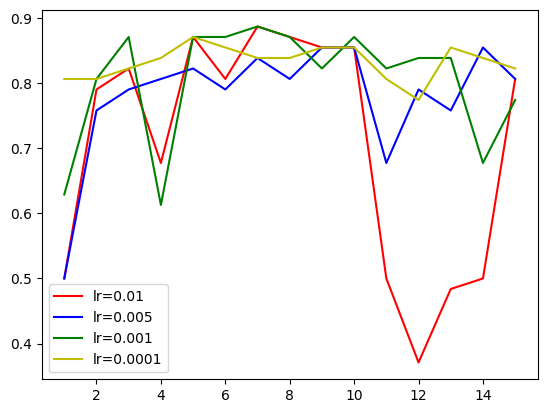

In [ ]:
# Epocas del eje X
VGG16_001_val_acc = VGG16_001_val_acc1 + VGG16_001_val_acc2
VGG16_0005_val_acc = VGG16_0005_val_acc1 + VGG16_0005_val_acc2
VGG16_0001_val_acc = VGG16_0001_val_acc1 + VGG16_0001_val_acc2
VGG16_00001_val_acc = VGG16_00001_val_acc1 + VGG16_00001_val_acc2
epochs = range(1, len(VGG16_001_val_acc) + 1)

# Representamos las gráficas
plt.plot(epochs, VGG16_001_val_acc, 'r', label='lr=0.01')
plt.plot(epochs, VGG16_0005_val_acc, 'b', label='lr=0.005')
plt.plot(epochs, VGG16_0001_val_acc, 'g', label='lr=0.001')
plt.plot(epochs, VGG16_00001_val_acc, 'y', label='lr=0.0001')

# Incluir leyenda
plt.legend(loc='best')

# Mostrar la figura
plt.show()